# 1 Dimensional model of tempreture diffusion 
$$
\frac{\partial u(x,t)}{\partial t} = c_p \frac{\partial^2 u(x,t)}{\partial x^2}$$




## Library imports

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

## PINN definition
Here we define classical architecture of PINN that is a feed forward fully connected neural network with tanh() activation function

In [3]:
class termPINN_1D(nn.Module):
    def __init__(self, num_hidden = 256, num_layers = 10):
        super(termPINN_1D, self).__init__()
        layers = []
        # Input: x,t
        layers.append(nn.Linear(2, num_hidden))
        layers.append(nn.Tanh())
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(num_hidden, num_hidden))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(num_hidden,1))
        self.net = nn.Sequential(*layers)
        
    # def _initialize_weights(self):
    #     for m in self.modules():
    #         if isinstance(m, nn.Linear):
    #             nn.init.xavier_normal_(m.weight)
    #             nn.init.zeros_(m.bias)   
                
    def forward(self, x):
        return self.net(x)

## Definition of collocation points

In [4]:
def generate_collocation_points(Nx=2**8, Nt = 2**8):
    x = torch.linspace(-1,1, Nx)
    t = torch.linspace(0,1,Nt)
    X, T = torch.meshgrid(x,t, indexing='ij')
    points = torch.stack([X.flatten(), T.flatten()], dim=-1)
    points.requires_grad_(True)
    return points, x,t 

## Define Partial Differential Equation

In [608]:
def derivative(x,y):
    df = torch.autograd.grad(x,y, grad_outputs=torch.ones_like(x).to(device), create_graph = True)[0]
    df_x = df[:, 0:1]
    df_t = df[:, 1:2]
    return df_x, df_t

def PDE(model, cp , points):
    Temp = model(points)
    dT_x, dT_t = derivative(Temp, points)
    dT_xx, _ = derivative(dT_x, points)
    pde = 1*(cp*dT_xx - dT_t)
    return pde

## Dirichlet conditions
def BC_right(model, right_border):
    return model(right_border)
    
def BC_left(model, left_border):
    return model(left_border)    
    
def IC(model, points):
    return model(points)

def compute_bc_ic_loss(model, bc_left_pt, bc_left_value, bc_right_pt, bc_right_value, ic_pt, ic_value):
    term1 = torch.mean((BC_right(model, bc_right_pt)[:,0] - bc_right_value)**2)
    term2 = torch.mean((BC_left(model, bc_left_pt)[:,0] - bc_left_value)**2)
    term3 = torch.mean((IC(model, ic_pt) - ic_value)**2)
    return term1 + term2 + 1000*term3 

    

## Define border and initial conditions

tensor([3.7835e-44, 3.7835e-44, 3.7835e-44,  ..., 3.7835e-44, 3.7835e-44,
        3.7835e-44], device='cuda:0', grad_fn=<ExpBackward0>)


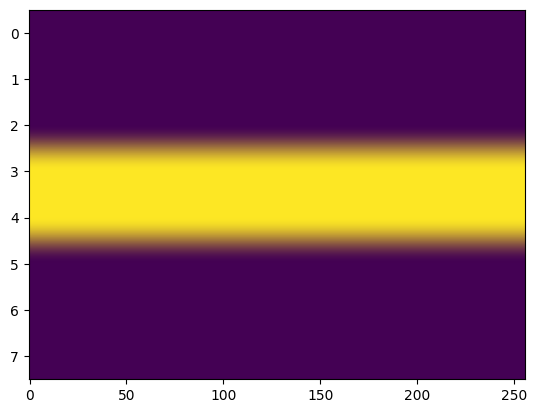

In [96]:
domain, x,t = generate_collocation_points(Nx=2**3, Nt=2**8)
domain = domain.to(device)
bc_right_pt = domain[domain[:,0] == -1].requires_grad_(True)
bc_left_pt = domain[domain[:,0] == 1].requires_grad_(True)
ic_pt = domain[domain[:,1] == 0].requires_grad_(True)
sigma = 0.01
ic_shift = 0.30
# signal = torch.exp(-(ic_pt-ic_shift)**2/sigma) + torch.exp(-(ic_pt+ic_shift)**2/sigma)

pulse_pos = [0.10, 0.45, 0.80]
pump = torch.zeros_like(t)
for center in pulse_pos:
    pump += torch.exp(-(t-center)**2/0.0005)
pump /= torch.max(pump)

pump = pump.to(device)

print(torch.exp(-(domain[:,0]**2)/0.01))

plt.imshow(torch.exp(-(domain[:,0]**2)/0.01).cpu().reshape(2**3, 2**8).detach().numpy(), aspect = 'auto')


# plt.plot(pulse_train(t))
    






## Training PINN

In [610]:
model = termPINN_1D(2,3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epoches = 10000
loss_eval = []
for epoch in range(epoches):
    optimizer.zero_grad()
    pde_residual = PDE(model, 0.1, domain)
    pde_loss = torch.mean(pde_residual**2)
    bc_ic_loss = compute_bc_ic_loss(model, bc_left_pt, 0, bc_right_pt, 0, ic_pt, signal)
    loss = pde_loss + bc_ic_loss
    loss.backward(retain_graph=True)
    optimizer.step()
    loss_eval.append(loss.item())

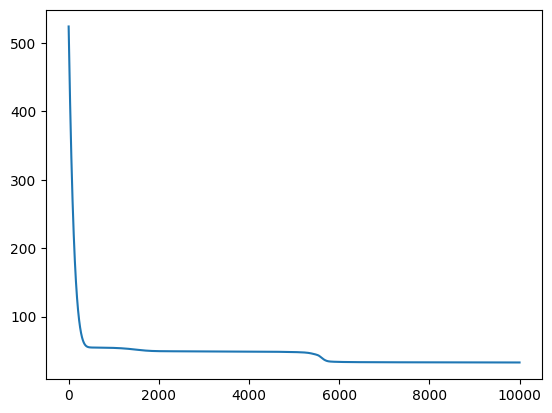

In [611]:
plt.plot(loss_eval)

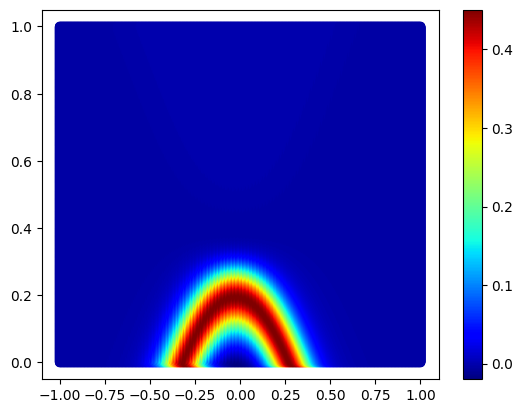

In [612]:
temp_dist = model(domain)
# temp_dist.reshape(100, 2**8)
plt.scatter(domain[:,0].detach().cpu().numpy(), domain[:,1].detach().cpu().numpy(), c= temp_dist.detach().cpu().numpy(), cmap = 'jet')
plt.colorbar()




# plt.imshow(temp_dist.detach().numpy(), aspect='auto', cmap = 'jet')
# print(len(temp_dist))
# plt.plot(temp_dist[:10000000000].detach().numpy())# plt.imshow(temp_dist.detach().numpy(), aspect='auto')

In [613]:
print(bc_right_pt)

tensor([[-1.0000,  0.0000],
        [-1.0000,  0.0010],
        [-1.0000,  0.0020],
        ...,
        [-1.0000,  0.9980],
        [-1.0000,  0.9990],
        [-1.0000,  1.0000]], device='cuda:0', grad_fn=<IndexBackward0>)
